In [ ]:
# ----------------------------------------------
# Part 1: Exploration & Preprocessing
# ----------------------------------------------

import pandas as pd

url = "https://raw.githubusercontent.com/SteffiPeTaffy/machineLearningAZ/master/Machine%20Learning%20A-Z%20Template%20Folder/Part%204%20-%20Clustering/Section%2025%20-%20Hierarchical%20Clustering/Mall_Customers.csv"
df = pd.read_csv(url)

# Drop CustomerID 
df.drop("CustomerID", axis=1, inplace=True)

# Show first 5 rows
display(df.head())
print("\n--- DATA INFO ---")
display(df.info())
print("\n--- DATA DESCRIBE ---")
display(df.describe())

In [2]:
# ----------------------------------------------
# Part 2: Features & Scaling
# ----------------------------------------------

from sklearn.preprocessing import StandardScaler

# Use the two features for clustering
X = df[["Annual Income (k$)", "Spending Score (1-100)"]]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


1 400.0
2 273.6688866264201
3 157.70400815035947
4 109.22822707921345
5 65.56840815571681
6 60.13287487193421
7 49.66824483736797
8 37.319122878338824
9 32.49508119910091
10 30.05932269404221


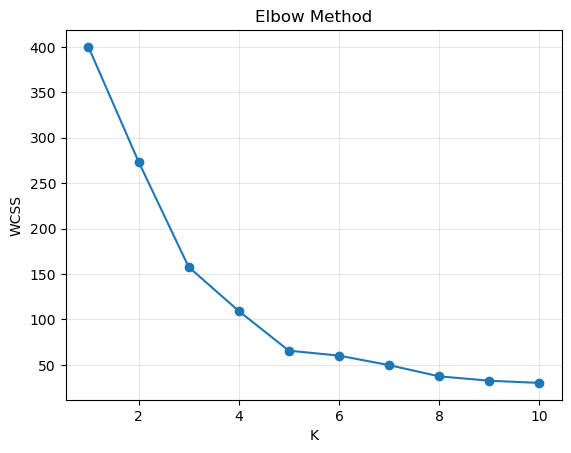

2 0.3973270007887498
3 0.46658474419000145
4 0.49434988482196796
5 0.5546571631111091
6 0.513825753467656
7 0.50200146805547
8 0.4550112502601921
9 0.4566624374485964
10 0.44475993501732874


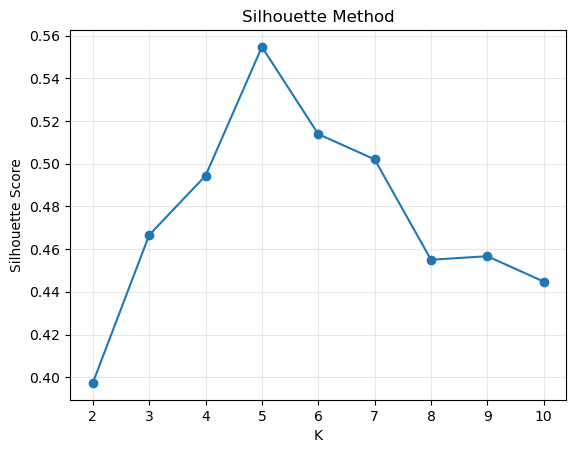

In [3]:
# ----------------------------------------------
# Part 3 — K-Means: Elbow Method
# ----------------------------------------------

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 10 + 1):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    wcss.append(km.inertia_)

for k, val in zip(range(1, 11), wcss):
    print(k, val)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("K")
plt.ylabel("WCSS")
plt.title("Elbow Method")
plt.grid(alpha=0.3)
plt.show()

# ----------------------------------------------
# Part 3 — Silhouette Score
# ----------------------------------------------

from sklearn.metrics import silhouette_score

sil_scores = []

for k in range(2, 11):        # K = 2 to 10
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)           
    score = silhouette_score(X_scaled, labels)  
    sil_scores.append(score)

for k, score in zip(range(2, 11), sil_scores):
    print(k, score)

plt.plot(range(2, 11), sil_scores, marker='o')
plt.xlabel("K")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Method")
plt.grid(alpha=0.3)
plt.show()


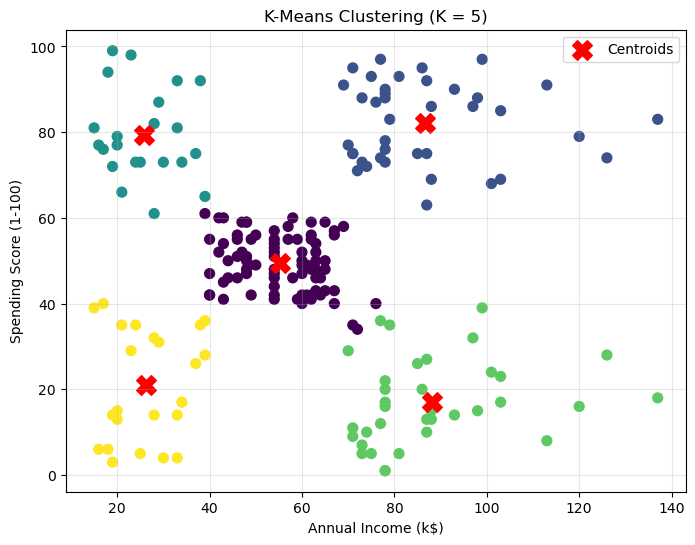

,Mean_Age,Mean_Income,Mean_Spending,Size
Cluster,,,,
0,42.716049,55.296296,49.518519,81
1,32.692308,86.538462,82.128205,39
2,25.272727,25.727273,79.363636,22
3,41.114286,88.200000,17.114286,35
4,45.217391,26.304348,20.913043,23


In [4]:
# ----------------------------------------------
# Part 4 — Final K-Means Model
# ----------------------------------------------

kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add to original DataFrame
df["Cluster"] = cluster_labels

plt.figure(figsize=(8,6))
plt.scatter(df["Annual Income (k$)"],
            df["Spending Score (1-100)"],
            c=df["Cluster"],
            cmap="viridis",
            s=50)

# Plot centroids
centroids = kmeans.cluster_centers_
centroids_original = scaler.inverse_transform(centroids)

plt.scatter(centroids_original[:,0],
            centroids_original[:,1],
            c="red",
            s=200,
            marker="X",
            label="Centroids")

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("K-Means Clustering (K = 5)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Table for clusters
cluster_summary = df.groupby("Cluster").agg(
    Mean_Age=("Age", "mean"),
    Mean_Income=("Annual Income (k$)", "mean"),
    Mean_Spending=("Spending Score (1-100)", "mean"),
    Size=("Cluster", "count")
)

cluster_summary

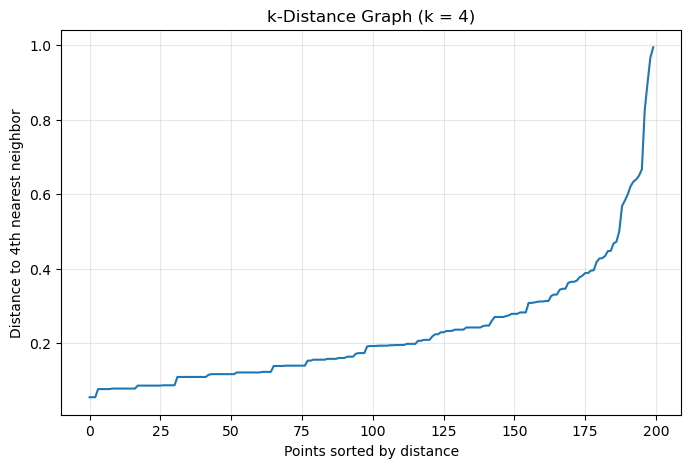

Suggested eps around knee (90th percentile): 0.4187
Suggested eps around knee (95th percentile): 0.5838
Chosen eps: 0.42
DBSCAN clusters: 2
Noise points: 13
Cluster labels: [np.int64(-1), np.int64(0), np.int64(1)]


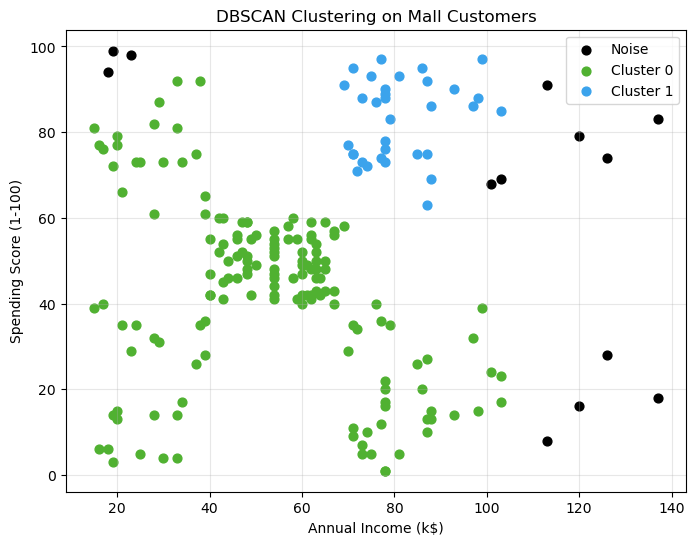

,Mean_Age,Mean_Income,Mean_Spending,Size
DBSCAN_Cluster,,,,
0,40.551948,53.123377,42.051948,154
1,32.727273,81.060606,83.000000,33


In [5]:
# ----------------------------------------------
# Part 5 — DBSCAN on Mall Customers
# ----------------------------------------------

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import numpy as np
import seaborn as sns

# K-distance graph
min_samples = 4
k = min_samples

nbrs = NearestNeighbors(n_neighbors=k).fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)

k_distances = distances[:, -1]
k_distances_sorted = np.sort(k_distances)

plt.figure(figsize=(8,5))
plt.plot(k_distances_sorted)
plt.title("k-Distance Graph (k = 4)")
plt.xlabel("Points sorted by distance")
plt.ylabel("Distance to 4th nearest neighbor")
plt.grid(alpha=0.3)
plt.show()

# Print suggested eps values
eps_suggestion_90 = np.percentile(k_distances, 90)
eps_suggestion_95 = np.percentile(k_distances, 95)

print("Suggested eps around knee (90th percentile):", round(eps_suggestion_90, 4))
print("Suggested eps around knee (95th percentile):", round(eps_suggestion_95, 4))

eps = 0.42
print("Chosen eps:", eps)

dbscan = DBSCAN(eps=eps, min_samples=4)
db_labels = dbscan.fit_predict(X_scaled)
df["DBSCAN_Cluster"] = db_labels


# Cluster counts 
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)

print("DBSCAN clusters:", n_clusters)
print("Noise points:", n_noise)
print("Cluster labels:", sorted(set(db_labels)))


# Plot DBSCAN clusters 
plt.figure(figsize=(8,6))

unique_labels = sorted(df["DBSCAN_Cluster"].unique())
colors = sns.color_palette("husl", len(unique_labels))

for label, color in zip(unique_labels, colors):
    mask = df["DBSCAN_Cluster"] == label
    if label == -1:
        plt.scatter(df.loc[mask, "Annual Income (k$)"],
                    df.loc[mask, "Spending Score (1-100)"],
                    c="black", s=40, label="Noise")
    else:
        plt.scatter(df.loc[mask, "Annual Income (k$)"],
                    df.loc[mask, "Spending Score (1-100)"],
                    c=[color], s=40, label=f"Cluster {label}")

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("DBSCAN Clustering on Mall Customers")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


# DBSCAN summary table 
dbscan_summary = df[df["DBSCAN_Cluster"] != -1].groupby("DBSCAN_Cluster").agg(
    Mean_Age=("Age", "mean"),
    Mean_Income=("Annual Income (k$)", "mean"),
    Mean_Spending=("Spending Score (1-100)", "mean"),
    Size=("DBSCAN_Cluster", "count")
)

dbscan_summary


In [6]:
# Identify outliers 
outliers = df[df["DBSCAN_Cluster"] == -1]
outliers.head()

,Genre,Age,Annual Income (k$),Spending Score (1-100),Cluster,DBSCAN_Cluster
7,Female,23,18,94,2,-1
11,Female,35,19,99,2,-1
19,Female,35,23,98,2,-1
187,Male,28,101,68,1,-1
191,Female,32,103,69,1,-1
